In [1]:
"INITIALIZE THE MCMC CLASS"



import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tqdm import tqdm
import time

# --- Best-effort: raise process priority and set CPU affinity / BLAS threads ---
# This tries to make the Python process more CPU-responsive on Windows and
# limit shared BLAS/OpenMP thread pools to the number of physical cores to
# reduce contention when the code spawns parallel work internally.
try:
    import os
    import psutil
    # set process priority (HIGH on Windows, nice -10 on Unix-like if permitted)
    proc = psutil.Process()
    try:
        if os.name == 'nt':
            proc.nice(psutil.HIGH_PRIORITY_CLASS)
        else:
            # negative niceness increases priority on Unix; may require permissions
            proc.nice(-10)
    except Exception as e:
        print("Could not change process priority:", e)

    # set CPU affinity to all logical CPUs (best-effort)
    try:
        cpus = list(range(psutil.cpu_count()))
        proc.cpu_affinity(cpus)
    except Exception as e:
        # on some platforms setting affinity may not be supported
        print("Could not set CPU affinity:", e)

    # try to restrict BLAS/OpenMP thread pools to physical core count
    phys = psutil.cpu_count(logical=False) or psutil.cpu_count()
    os.environ.setdefault("OMP_NUM_THREADS", str(phys))
    os.environ.setdefault("OPENBLAS_NUM_THREADS", str(phys))
    os.environ.setdefault("MKL_NUM_THREADS", str(phys))
    os.environ.setdefault("NUMEXPR_NUM_THREADS", str(phys))

    try:
        # threadpoolctl can apply limits to already-imported libraries
        from threadpoolctl import threadpool_limits
        threadpool_limits(phys)
        print(f"Set threadpool limits to {phys} threads")
    except Exception:
        print("threadpoolctl not available; env var hints applied (best-effort)")

    print(f"Process priority/affinity best-effort applied. Physical cores: {phys}")
except Exception as e:
    print("psutil not available or cannot adjust process settings:", e)

class MCMCDDenoiser:
    """
    Markov-chain Monte Carlo Denoising (MCMCD) implementation
    Based on Wong et al. (2011) paper
    """
    
    def __init__(self, image, sigma_s=21, region_radius=3):
        """
        Initialize MCMCD denoiser
        
        Parameters:
        -----------
        image : ndarray
            Input noisy image
        sigma_s : float
            Standard deviation of random walk (default: 21)
        region_radius : int
            Radius of local patch (default: 3)
        """
        self.sigma_s = sigma_s
        self.region_radius = region_radius
        self.padded_image = np.pad(image, self.region_radius, mode='reflect')
        
    def get_local_region_circ(self, s):
        """Extract local circular region around site s"""
        y, x = s
        y += self.region_radius
        x += self.region_radius

        radius = self.region_radius        
        # Create circular mask
        y_coords, x_coords = np.ogrid[-radius:radius+1, -radius:radius+1]
        mask = x_coords**2 + y_coords**2 <= radius**2
        
        # Extract region with boundary handling
        y_min = y - radius
        y_max = y + radius + 1
        x_min = x - radius
        x_max = x + radius + 1
        
        region = self.padded_image[y_min:y_max, x_min:x_max]
        
        return region * mask
    
    def get_local_region_square(self, s):
        """Extract local square region around site s"""
        y, x = s
        y += self.region_radius
        x += self.region_radius

        
        # Extract region with boundary handling
        y_min = y - self.region_radius
        y_max = y + self.region_radius + 1
        x_min = x - self.region_radius
        x_max = x + self.region_radius + 1
        
        region = self.padded_image[y_min:y_max, x_min:x_max]
        
        return region
    
    def compute_objective(self, s0, sk, sigma_n_sq, sigma_l_sq):
        """
        Compute Geman-McClure objective function (Eq. 9)
        
        Parameters:
        -----------
        s0 : tuple
            Reference site (y, x)
        sk : tuple
            Candidate site (y, x)
        sigma_n_sq : float
            Noise variance
        sigma_l_sq : float
            Local variance
        """
        # Get local regions
        region_s0 = self.get_local_region_circ(s0)
        region_sk = self.get_local_region_circ(sk)
        
        # Compute Geman-McClure error statistics
        diff = region_sk - region_s0
        diff_sq = diff ** 2
        
        # Avoid division by zero
        denominator = ((sigma_n_sq**2)/(sigma_l_sq)) + diff_sq
        denominator = np.maximum(denominator, 1e-10)
        
        exponent = -np.sum(diff_sq / denominator)
        
        return np.exp(exponent)
    
    def estimate_noise_variance(self, image):
        """Estimate noise variance using median absolute deviation"""
        # Use high-frequency component estimation
        # diff_h = np.diff(image, axis=0)
        # diff_v = np.diff(image, axis=1)
        # sigma = np.median(np.abs(np.concatenate([diff_h.flatten(), diff_v.flatten()]))) / 0.6745
        # sigma = sigma / np.sqrt(2)  # Adjust for differencing
        # return sigma ** 2
        return np.var(image)
    
    def estimate_local_variance(self, s):
        """Estimate local variance around site s"""
        region = self.get_local_region_square(s)
        return self.estimate_noise_variance(region)
    
    def denoise(self, num_iterations = 100, noisy_image = None, verbose=False):
        """
        Denoise image using MCMCD
        
        Parameters:
        -----------
        noisy_image : ndarray
            Noisy input image
        sigma_n : float, optional
            Known noise standard deviation (if None, will be estimated)
        verbose : bool
            Print progress information
        
        Returns:
        --------
        denoised_image : ndarray
            Denoised image
        """
        if(noisy_image is None):
            size = self.padded_image.shape[0] - 2 * self.region_radius
            F = self.padded_image[self.region_radius:self.region_radius+size,
                                            self.region_radius:self.region_radius+size]
        else:
            F = noisy_image.copy()
        h, w = F.shape
        
        # Estimate noise variance if not provided
        sigma_n_sq = self.estimate_noise_variance(F)

        #local variance matrix
        local_variance_matrix = np.zeros((h, w))
        for i in range(h):
            for j in range(w):
                s = (i, j)
                local_variance_matrix[i, j] = self.estimate_local_variance(s)
        
        if verbose:
            # print(f"Image size: {h}x{w}")
            # print(f"Noise var: {sigma_n_sq:.2f}")
            # print(f"MCMC iterations per pixel: {num_iterations}")
            print(f"Processing pixels...")
        
        denoised = np.zeros_like(F)
        
        # Process each pixel with progress bar
        total_pixels = h * w
        pixel_iterator = tqdm(np.ndindex(h, w), 
                             total=total_pixels,
                             desc="Denoising",
                             unit="pixels",
                             disable=not verbose,
                             ncols=80)
        
        for (i, j) in pixel_iterator:
            s0 = (i, j)
            sigma_l_sq = local_variance_matrix[i,j]
            
            # MCMC sampling
            probabilities = np.zeros(256)
            s_prev = s0
            
            for k in range(num_iterations):
                # Draw candidate sample from instrumental distribution (Gaussian)
                dy = np.random.normal(0, self.sigma_s)
                dx = np.random.normal(0, self.sigma_s)
                
                sk_y = int(np.clip(s_prev[0] + dy, 0, h - 1))
                sk_x = int(np.clip(s_prev[1] + dx, 0, w - 1))
                sk = (sk_y, sk_x)
                
                # Compute acceptance probability
                f_sk = self.compute_objective(s0, sk, sigma_n_sq, sigma_l_sq)
                f_prev = self.compute_objective(s0, s_prev, sigma_n_sq, sigma_l_sq)
                
                # Avoid division by zero
                if f_prev > 0:
                    acceptance_prob = min(1.0, f_sk / f_prev)
                else:
                    acceptance_prob = 1.0
                
                # Accept or reject
                u = np.random.uniform(0, 1)
                if u <= acceptance_prob:
                    probabilities[int(F[sk])] += f_sk * np.exp((-np.abs(F[sk] - F[s0]))/255)
                    # samples.append(sk)
                    # weights.append(f_sk)
                    s_prev = sk
            
            # # Estimate posterior and compute conditional mean
            # if len(samples) > 0 and np.sum(weights) > 0:
            #     # Importance-weighted posterior estimation
            #     intensities = [F[s] for s in samples]
            #     weights = np.array(weights)
            #     weights = weights / np.sum(weights)  # Normalize
                
            #     # Conditional mean

            #     denoised[i, j] = np.sum(intensities * weights)
            # else:
            #     # Fallback to original value if no samples
            #     denoised[i, j] = F[i, j]

            Z = np.sum(probabilities)
            if Z != 0:
                probabilities /= Z
                bins = np.linspace(0, 255, 256)
                denoised[i, j] = np.clip(int(np.sum((probabilities * bins))), 0, 255)
            else:
                denoised[i, j] = F[i, j]
        
        if verbose:
            print("\nDenoising complete!")
        
        return denoised

Set threadpool limits to 4 threads
Process priority/affinity best-effort applied. Physical cores: 4


In [ ]:
"Generate test images and run MCMCD denoising tests"



def generate_test_image(size=128, pattern='camera'):
    """
    Generate test images from scipy.datasets and other sources
    
    Parameters:
    -----------
    size : int
        Image size (will be resized to size x size)
    pattern : str
        Image type: 'camera', 'astronaut', 'coins', 'moon', 'text', 'checkerboard'
    """
    from scipy import datasets, ndimage
    from skimage import transform, color, util, data
    
    if pattern == 'camera':
        # Camera image (512x512 grayscale)
        image = datasets.face(gray=True)
        
    elif pattern == 'astronaut':
        # Astronaut image (needs conversion to grayscale)
        image = data.astronaut()
        image = color.rgb2gray(image) * 255.0
        
    elif pattern == 'coffee':
        image = data.coffee()
        image = color.rgb2gray(image) * 255.0
        
    elif pattern == 'chelsea':
        image = data.chelsea()
        image = color.rgb2gray(image) * 255.0
    elif pattern == 'horse':
        image = data.horse()
        image = util.img_as_float(image) * 255.0
    
    else:
        # Default to ascent image
        image = datasets.ascent()
    
    # Resize to desired size
    if image.shape != (size, size):
        from skimage import transform
        image = transform.resize(image, (size, size), anti_aliasing=True, preserve_range=True)
    
    return np.clip(image, 0, 255)


def add_gaussian_noise(image, sigma):
    """Add Gaussian noise to image"""
    noise = np.random.normal(0, sigma, image.shape)
    noisy = image + noise
    return np.clip(noisy, 0, 255)

# --- Best-effort: set BLAS/OpenMP thread-limits for numerical libraries ---
# This helps avoid oversubscription when using many Python threads/processes.
try:
    import os
    import psutil
    phys = psutil.cpu_count(logical=False) or psutil.cpu_count()
    os.environ.setdefault("OMP_NUM_THREADS", str(phys))
    os.environ.setdefault("OPENBLAS_NUM_THREADS", str(phys))
    os.environ.setdefault("MKL_NUM_THREADS", str(phys))
    os.environ.setdefault("NUMEXPR_NUM_THREADS", str(phys))
    try:
        from threadpoolctl import threadpool_limits
        threadpool_limits(phys)
        print(f"Applied threadpool limits: {phys} threads")
    except Exception:
        print("threadpoolctl not installed; applied env var hints only")
except Exception as e:
    print("Could not apply thread limits:", e)

from skimage.metrics import structural_similarity, peak_signal_noise_ratio

def image_similarity(img1, img2):
    ssim_score, _ = structural_similarity(img1, img2, full=True)
    psnr_score = peak_signal_noise_ratio(img1, img2)
    return ssim_score, psnr_score


def test_denoising(num_iterations, image_size=128, noise_sigma=5, pattern='chelsea'):
    """
    Test MCMCD denoising on test image
    
    Parameters:
    -----------
    image_size : int
        Size of test image
    noise_sigma : float
        Standard deviation of Gaussian noise
    pattern : str
        Image type: 'camera', 'astronaut', 'coins', 'moon', 'text', 'checkerboard'
    """
    
    # Generate original image
    # print(f"\n1. Generating {pattern} test image ({image_size}x{image_size})...")
    # original = generate_test_image(image_size, pattern)
    # Load external image (grayscale), resize to image_size x image_size

    import PIL.Image as Image
    path = "testImage.jpg"
    img = Image.open(path).convert("L")
    if img.size != (image_size, image_size):
        img = img.resize((image_size, image_size), Image.LANCZOS)
    original = np.asarray(img, dtype=np.float32)
    original = np.clip(original, 0, 255)
    
    # Add noise
    # print(f"2. Adding Gaussian noise (σ = {noise_sigma})...")
    noisy = add_gaussian_noise(original, noise_sigma)
    
    # Denoise
    print(f"3. Denoising with MCMCD...")
    print(f"Image: {pattern} | Noise σ: {noise_sigma} | Iterations: {num_iterations}")
    denoiser = MCMCDDenoiser(noisy, sigma_s=21, region_radius=3)
    
    start_time = time.time()
    denoised = denoiser.denoise(num_iterations, verbose=True)
    elapsed_time = time.time() - start_time

    noisy = noisy.astype(np.uint8)
    denoised = denoised.astype(np.uint8)
    
    # Calculate metrics
    psnr_noisy = peak_signal_noise_ratio(original, noisy, data_range=255)
    psnr_denoised = peak_signal_noise_ratio(original, denoised, data_range=255)
    
    ssim_noisy = structural_similarity(original, noisy, data_range=255)
    ssim_denoised = structural_similarity(original, denoised, data_range=255)
    
    print(f"Time: {elapsed_time:.2f}s | Noisy: PSNR={psnr_noisy:.2f}dB, SSIM={ssim_noisy:.4f} | Denoised: PSNR={psnr_denoised:.2f}dB, SSIM={ssim_denoised:.4f} | ΔPSNR={psnr_denoised - psnr_noisy:.2f}dB, ΔSSIM={ssim_denoised - ssim_noisy:.4f}")
    
    # Display results
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(original, cmap='gray', vmin=0, vmax=255)
    axes[0].set_title('Original Image', fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    axes[1].imshow(noisy, cmap='gray', vmin=0, vmax=255)
    axes[1].set_title(f'Noisy Image\nPSNR: {psnr_noisy:.2f} dB, SSIM: {ssim_noisy:.4f}', 
                      fontsize=12)
    axes[1].axis('off')
    
    axes[2].imshow(denoised, cmap='gray', vmin=0, vmax=255)
    axes[2].set_title(f'Denoised Image (MCMCD)\nPSNR: {psnr_denoised:.2f} dB, SSIM: {ssim_denoised:.4f}', 
                      fontsize=12)
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return original, noisy, denoised

# Example usage
if __name__ == "__main__":
    # Test with different images and noise levels
    print("Running MCMCD Denoising Tests\n")
    
    # Test 1: Camera/Face image with moderate noise
    test_denoising(num_iterations = 100, image_size=256, noise_sigma=30, pattern='camera')
    
#     # Uncomment to test other images:
#     # test_denoising(image_size=128, noise_sigma=25, pattern='astronaut')
#     # test_denoising(image_size=128, noise_sigma=20, pattern='coins')
#     # test_denoising(image_size=128, noise_sigma=30, pattern='moon')
#     # test_denoising(image_size=128, noise_sigma=20, pattern='text')
#     # test_denoising(image_size=128, noise_sigma=25, pattern='checkerboard')

Applied threadpool limits: 4 threads
Running MCMCD Denoising Tests

3. Denoising with MCMCD...
Image: camera | Noise σ: 30 | Iterations: 100


,Point Index,Y Coord,X Coord,Local Var (np.var),Local Var (HF Estimation),Global^4 / Local^2 (np.var),Global^4 / Local^2 (HF)
0,0,58,180,2.144389,0.000000,6.190663e+06,inf
1,1,41,207,2.102315,0.000000,6.314557e+06,inf
2,2,40,14,0.696947,0.000000,1.904763e+07,inf
3,3,135,141,483.436924,299.208540,2.746002e+04,0.326982
4,4,3,137,1.686087,0.000000,7.873372e+06,inf
5,5,69,0,0.649546,0.000000,2.043765e+07,inf
6,6,74,0,0.916741,0.000000,1.448086e+07,inf
7,7,87,40,0.942149,0.000000,1.409033e+07,inf
8,8,128,252,118.506523,17586.813064,1.120208e+05,0.005563
9,9,242,2,1.408374,1.099021,9.425900e+06,89.020723


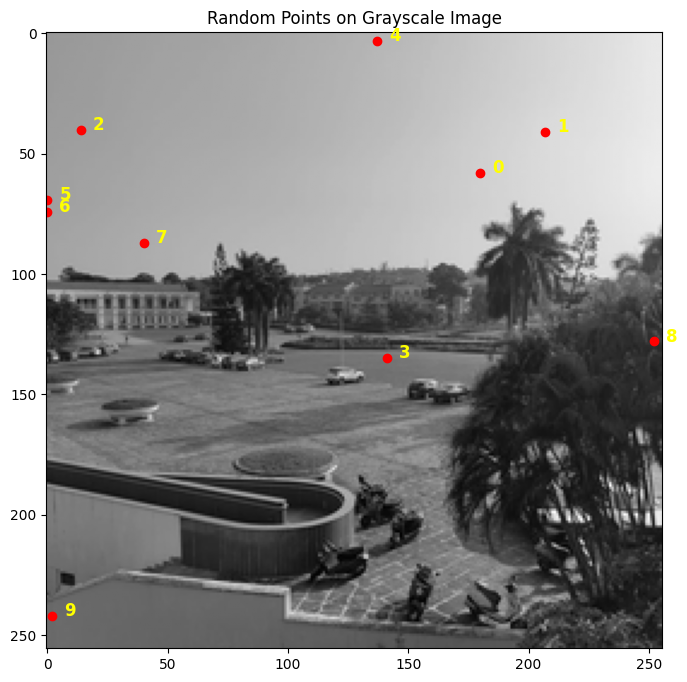

In [11]:
"np.var vs High-Frequency Variance Estimation Comparison"



import numpy as np
import pandas as pd
from PIL import Image

import matplotlib.pyplot as plt

# Load grayscale image (resized and clamped to 0-255 as uint8)
original = np.clip(np.array(Image.open("testImage.jpg").convert("L").resize((256, 256), Image.LANCZOS)), 0, 255).astype(np.uint8)

h, w = original.shape

# Randomly choose 10 points
num_points = 10
ys = np.random.randint(0, h, size=num_points)
xs = np.random.randint(0, w, size=num_points)
random_points = list(zip(ys, xs))

# Initialize denoiser for region extraction
denoiser = MCMCDDenoiser(original, region_radius=5)

# Helper for high-frequency variance estimation
def high_freq_var(region):
    diff_h = np.diff(region, axis=0)
    diff_v = np.diff(region, axis=1)
    sigma = np.median(np.abs(np.concatenate([diff_h.flatten(), diff_v.flatten()]))) / 0.6745
    sigma = sigma / np.sqrt(2)
    return sigma ** 2

results = []
for idx, (y, x) in enumerate(random_points):
    region = denoiser.get_local_region_square((y, x))
    var_np = float(np.var(region))
    var_hf = float(high_freq_var(region))
    results.append({
        "Point Index": idx,
        "Y Coord": y,
        "X Coord": x,
        "Local Var (np.var)": var_np,
        "Local Var (HF Estimation)": var_hf
    })

# Calculate global variance
global_var_npvar = float(np.var(original))
global_var_hf = float(high_freq_var(original))

# Add global row
results.append({
    "Point Index": "GLOBAL",
    "Y Coord": "-",
    "X Coord": "-",
    "Local Var (np.var)": global_var_npvar,
    "Local Var (HF Estimation)": global_var_hf
})

# Tabulate and add ratio columns
df = pd.DataFrame(results)
df["Global^4 / Local^2 (np.var)"] = (global_var_npvar ** 2) / (df["Local Var (np.var)"])
df["Global^4 / Local^2 (HF)"] = (global_var_hf ** 2) / (df["Local Var (HF Estimation)"])

# Show table
display(df)

# Plot image and points
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(original, cmap='gray')
for idx, (y, x) in enumerate(random_points):
    ax.plot(x, y, 'ro')
    ax.text(x+5, y, str(idx), color='yellow', fontsize=12, fontweight='bold')
ax.set_title("Random Points on Grayscale Image")
plt.show()

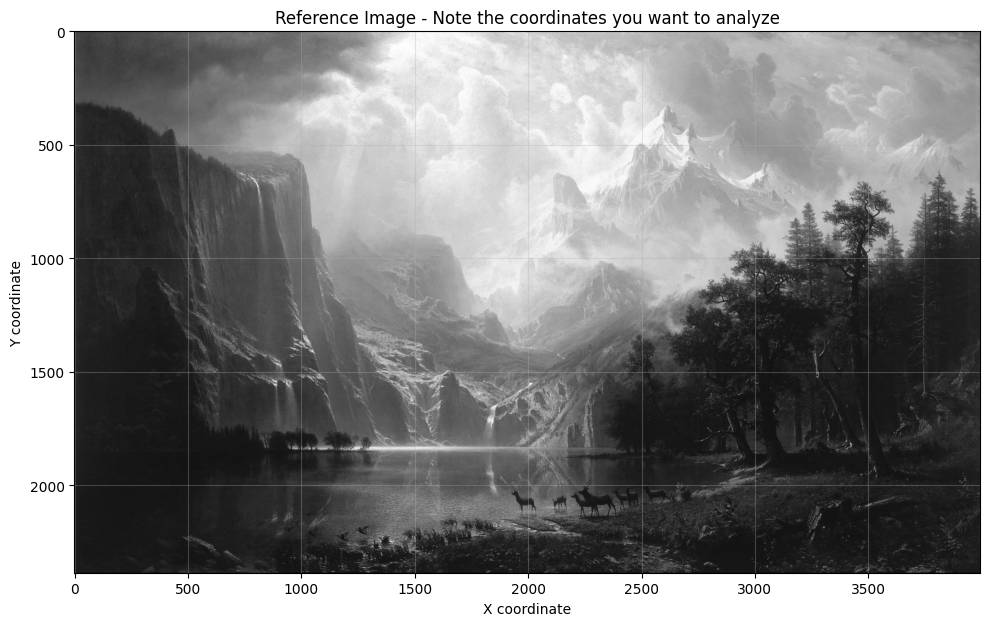

Image dimensions: 3993 x 2387 (width x height)
Enter coordinates to analyze, or press Enter for center point

Selected point: (2000, 2000)
Noise variance (np.var): 5330.6846
Local variance (np.var): 205.2548
Local variance (HF): 9.8912


,Iteration,Y,X,Objective (np.var),Objective (HF)
0,0,1989,2012,0.805264,0.971153
1,1,1970,1977,0.829038,0.990897
2,2,1971,1971,0.707212,0.934905
3,3,1961,2004,0.824027,0.987209
4,4,1939,2017,0.800036,0.989152
5,5,1988,2045,0.866375,0.987697
6,6,1959,2036,0.796254,0.988969
7,7,1950,2024,0.845887,0.985650
8,8,1978,2027,0.811122,0.989850
9,9,1994,2041,0.862534,0.980309


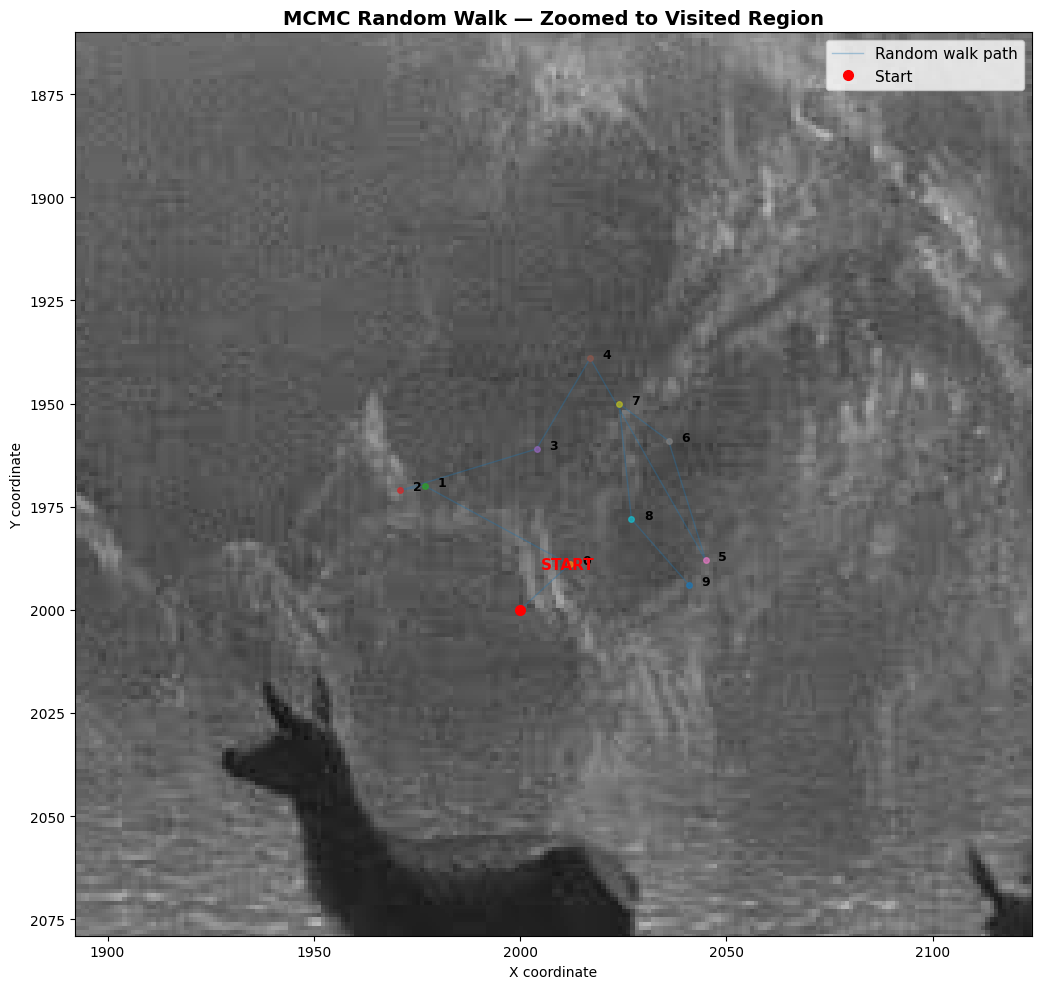

In [4]:
"Objective Function Behavior with Different Variance Estimations"



# Simple coordinate input approach (most reliable for all environments)
import matplotlib.pyplot as plt
import pandas as pd

# Display the image for reference
fig_ref, ax_ref = plt.subplots(figsize=(10, 8))
ax_ref.imshow(original, cmap='gray', vmin=0, vmax=255)
ax_ref.set_title('Reference Image - Note the coordinates you want to analyze', fontsize=12)
ax_ref.set_xlabel('X coordinate')
ax_ref.set_ylabel('Y coordinate')
ax_ref.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Simple input method - just type coordinates
print(f"Image dimensions: {w} x {h} (width x height)")
print("Enter coordinates to analyze, or press Enter for center point")
user_input = input("Enter as 'x,y' (e.g., '100,200'): ").strip()

if user_input:
    try:
        parts = user_input.split(',')
        sel_x = int(parts[0].strip())
        sel_y = int(parts[1].strip())
        sel_x = int(np.clip(sel_x, 0, w - 1))
        sel_y = int(np.clip(sel_y, 0, h - 1))
    except:
        print("Invalid input, using center point")
        sel_x, sel_y = w // 2, h // 2
else:
    # Default to center
    sel_x, sel_y = w // 2, h // 2

s0 = (sel_y, sel_x)
print(f"\nSelected point: ({sel_y}, {sel_x})")

# Estimate variances for this point
sigma_n_sq_np = np.var(original)
sigma_l_sq_np = denoiser.estimate_local_variance(s0)
sigma_l_sq_hf = high_freq_var(denoiser.get_local_region_square(s0))

print(f"Noise variance (np.var): {sigma_n_sq_np:.4f}")
print(f"Local variance (np.var): {sigma_l_sq_np:.4f}")
print(f"Local variance (HF): {sigma_l_sq_hf:.4f}")

# Track visited pixels during MCMC
visited_pixels = []
objective_values_np = []
objective_values_hf = []

# Perform MCMC sampling
sigma_s = 21
num_iterations = 10

s_prev = s0
for k in range(num_iterations):
    dy = np.random.normal(0, sigma_s)
    dx = np.random.normal(0, sigma_s)
    
    sk_y = int(np.clip(s_prev[0] + dy, 0, h - 1))
    sk_x = int(np.clip(s_prev[1] + dx, 0, w - 1))
    sk = (sk_y, sk_x)
    
    # Compute objectives with both variance methods
    f_sk_np = denoiser.compute_objective(s0, sk, sigma_n_sq_np, sigma_l_sq_np)
    f_prev_np = denoiser.compute_objective(s0, s_prev, sigma_n_sq_np, sigma_l_sq_np)
    
    sigma_l_sq_sk_hf = high_freq_var(denoiser.get_local_region_square(sk))
    sigma_l_sq_prev_hf = high_freq_var(denoiser.get_local_region_square(s_prev))
    f_sk_hf = denoiser.compute_objective(s0, sk, sigma_n_sq_np, sigma_l_sq_sk_hf)
    f_prev_hf = denoiser.compute_objective(s0, s_prev, sigma_n_sq_np, sigma_l_sq_prev_hf)
    
    visited_pixels.append(sk)
    objective_values_np.append(float(f_sk_np))
    objective_values_hf.append(float(f_sk_hf))
    
    # Acceptance probability
    if f_prev_np > 0:
        acceptance_prob = min(1.0, f_sk_np / f_prev_np)
    else:
        acceptance_prob = 1.0
    
    u = np.random.uniform(0, 1)
    if u <= acceptance_prob:
        s_prev = sk

# Create results table
mcmc_results = []
for idx, (py, px) in enumerate(visited_pixels):
    mcmc_results.append({
        'Iteration': idx,
        'Y': py,
        'X': px,
        'Objective (np.var)': objective_values_np[idx],
        'Objective (HF)': objective_values_hf[idx]
    })

df_mcmc = pd.DataFrame(mcmc_results)
display(df_mcmc)

# --- Build the path (include the start) ---
xs_path = [sel_x] + [p[1] for p in visited_pixels]
ys_path = [sel_y] + [p[0] for p in visited_pixels]

# --- Compute tight bounds around all visited points + start ---
all_x = xs_path
all_y = ys_path
min_x, max_x = min(all_x), max(all_x)
min_y, max_y = min(all_y), max(all_y)

# A little padding so markers/labels don't hug the edges
pad = max(5, int(0.02 * max(h, w)))
x0 = np.clip(min_x - pad, 0, w - 1)
x1 = np.clip(max_x + pad, 0, w - 1)
y0 = np.clip(min_y - pad, 0, h - 1)
y1 = np.clip(max_y + pad, 0, h - 1)

# --- Plot ---
fig, ax = plt.subplots(figsize=(12, 10))
ax.imshow(original, cmap='gray', vmin=0, vmax=255)

# Path (start -> last)
ax.plot(xs_path, ys_path, '-', alpha=0.35, linewidth=1, label='Random walk path')

# Visited pixels (label with iteration index)
for idx, (y, x) in enumerate(visited_pixels):
    ax.plot(x, y, '.', markersize=8, alpha=0.7)
    ax.text(x + 3, y, str(idx), fontsize=9, fontweight='bold')

# Initial point as a RED DOT
ax.plot(sel_x, sel_y, 'r.', markersize=14, label='Start')
ax.text(sel_x + 5, sel_y - 10, 'START', color='red', fontsize=11, fontweight='bold')

# --- Zoom to fit all points visited ---
ylim0, ylim1 = ax.get_ylim()
if ylim0 > ylim1:
    ax.set_ylim(y1, y0)
else:
    ax.set_ylim(y0, y1)
ax.set_xlim(x0, x1)

ax.set_title('MCMC Random Walk — Zoomed to Visited Region', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')
plt.tight_layout()
plt.show()

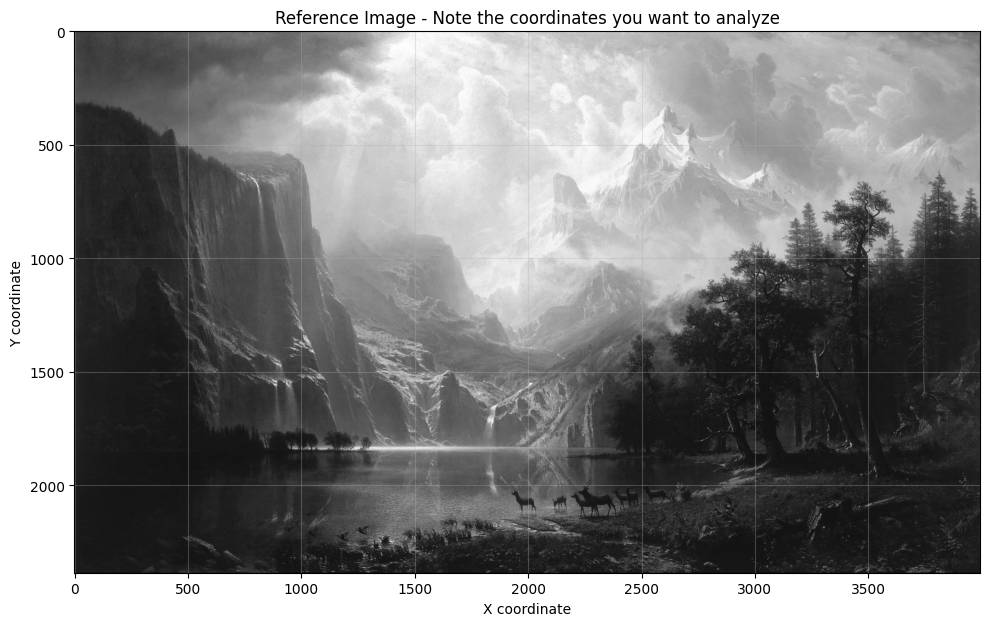

Image dimensions: 3993 x 2387 (width x height)
Enter coordinates to analyze, or press Enter for center point

Selected point: (2000, 2000)
Noise variance (np.var): 5330.6846
Local variance (np.var): 205.2548
Local variance (HF): 9.8912


,Iteration,Y,X,Objective (np.var),Intensity
0,0,2021,2009,0.843763,79.0
1,1,2018,2006,0.841446,82.0
2,2,2017,1985,0.845783,80.0
3,3,2008,1985,0.840123,90.0
4,4,2010,1979,0.850186,77.0
5,5,2017,1998,0.818931,81.0
6,6,2019,1999,0.843958,91.0
7,7,2010,2001,0.835508,83.0
8,8,2009,2008,0.852374,88.0
9,9,2003,2006,0.808598,99.0


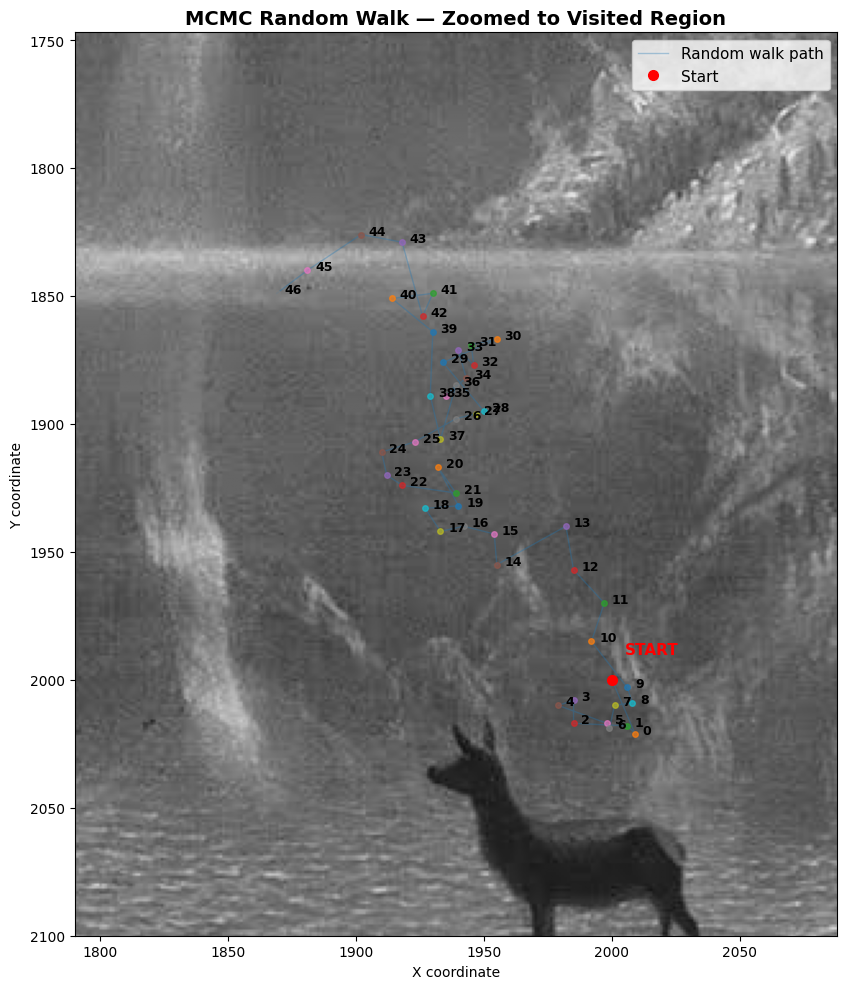

In [5]:
"Objective function with actual pixel selection criteria (np.var only)"



# Simple coordinate input approach (most reliable for all environments)
import matplotlib.pyplot as plt
import pandas as pd

# Display the image for reference
fig_ref, ax_ref = plt.subplots(figsize=(10, 8))
ax_ref.imshow(original, cmap='gray', vmin=0, vmax=255)
ax_ref.set_title('Reference Image - Note the coordinates you want to analyze', fontsize=12)
ax_ref.set_xlabel('X coordinate')
ax_ref.set_ylabel('Y coordinate')
ax_ref.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Simple input method - just type coordinates
print(f"Image dimensions: {w} x {h} (width x height)")
print("Enter coordinates to analyze, or press Enter for center point")
user_input = input("Enter as 'x,y' (e.g., '100,200'): ").strip()

if user_input:
    try:
        parts = user_input.split(',')
        sel_x = int(parts[0].strip())
        sel_y = int(parts[1].strip())
        sel_x = int(np.clip(sel_x, 0, w - 1))
        sel_y = int(np.clip(sel_y, 0, h - 1))
    except:
        print("Invalid input, using center point")
        sel_x, sel_y = w // 2, h // 2
else:
    # Default to center
    sel_x, sel_y = w // 2, h // 2

s0 = (sel_y, sel_x)
print(f"\nSelected point: ({sel_y}, {sel_x})")

# Estimate variances for this point
sigma_n_sq_np = np.var(original)
sigma_l_sq_np = denoiser.estimate_local_variance(s0)
sigma_l_sq_hf = high_freq_var(denoiser.get_local_region_square(s0))

print(f"Noise variance (np.var): {sigma_n_sq_np:.4f}")
print(f"Local variance (np.var): {sigma_l_sq_np:.4f}")
print(f"Local variance (HF): {sigma_l_sq_hf:.4f}")

# Track visited pixels during MCMC
visited_pixels = []
objective_values_np = []
intensities_visited = []

# Perform MCMC sampling
sigma_s = 10
num_iterations = 50

s_prev = s0
for k in range(num_iterations):
    dy = np.random.normal(0, sigma_s)
    dx = np.random.normal(0, sigma_s)
    
    sk_y = int(np.clip(s_prev[0] + dy, 0, h - 1))
    sk_x = int(np.clip(s_prev[1] + dx, 0, w - 1))
    sk = (sk_y, sk_x)
    
    # Compute objectives with both variance methods
    f_sk_np = denoiser.compute_objective(s0, sk, sigma_n_sq_np, sigma_l_sq_np)
    f_prev_np = denoiser.compute_objective(s0, s_prev, sigma_n_sq_np, sigma_l_sq_np)
    
    # Acceptance probability
    if f_prev_np > 0:
        acceptance_prob = min(1.0, f_sk_np / f_prev_np)
    else:
        acceptance_prob = 1.0
    
    u = np.random.uniform(0, 1)
    if u <= acceptance_prob:
        visited_pixels.append(sk)
        objective_values_np.append(float(f_sk_np))
        intensities_visited.append(original[sk])
        s_prev = sk

# Create results table
mcmc_results = []
for idx, (py, px) in enumerate(visited_pixels):
    mcmc_results.append({
        'Iteration': idx,
        'Y': py,
        'X': px,
        'Objective (np.var)': objective_values_np[idx],
        'Intensity': intensities_visited[idx]
    })

df_mcmc = pd.DataFrame(mcmc_results)
display(df_mcmc)

# --- Build the path (include the start) ---
xs_path = [sel_x] + [p[1] for p in visited_pixels]
ys_path = [sel_y] + [p[0] for p in visited_pixels]

# --- Compute tight bounds around all visited points + start ---
all_x = xs_path
all_y = ys_path
min_x, max_x = min(all_x), max(all_x)
min_y, max_y = min(all_y), max(all_y)

# A little padding so markers/labels don't hug the edges
pad = max(5, int(0.02 * max(h, w)))
x0 = np.clip(min_x - pad, 0, w - 1)
x1 = np.clip(max_x + pad, 0, w - 1)
y0 = np.clip(min_y - pad, 0, h - 1)
y1 = np.clip(max_y + pad, 0, h - 1)

# --- Plot ---
fig, ax = plt.subplots(figsize=(12, 10))
ax.imshow(original, cmap='gray', vmin=0, vmax=255)

# Path (start -> last)
ax.plot(xs_path, ys_path, '-', alpha=0.35, linewidth=1, label='Random walk path')

# Visited pixels (label with iteration index)
for idx, (y, x) in enumerate(visited_pixels):
    ax.plot(x, y, '.', markersize=8, alpha=0.7)
    ax.text(x + 3, y, str(idx), fontsize=9, fontweight='bold')

# Initial point as a RED DOT
ax.plot(sel_x, sel_y, 'r.', markersize=14, label='Start')
ax.text(sel_x + 5, sel_y - 10, 'START', color='red', fontsize=11, fontweight='bold')

# --- Zoom to fit all points visited ---
ylim0, ylim1 = ax.get_ylim()
if ylim0 > ylim1:
    ax.set_ylim(y1, y0)
else:
    ax.set_ylim(y0, y1)
ax.set_xlim(x0, x1)

ax.set_title('MCMC Random Walk — Zoomed to Visited Region', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')
plt.tight_layout()
plt.show()

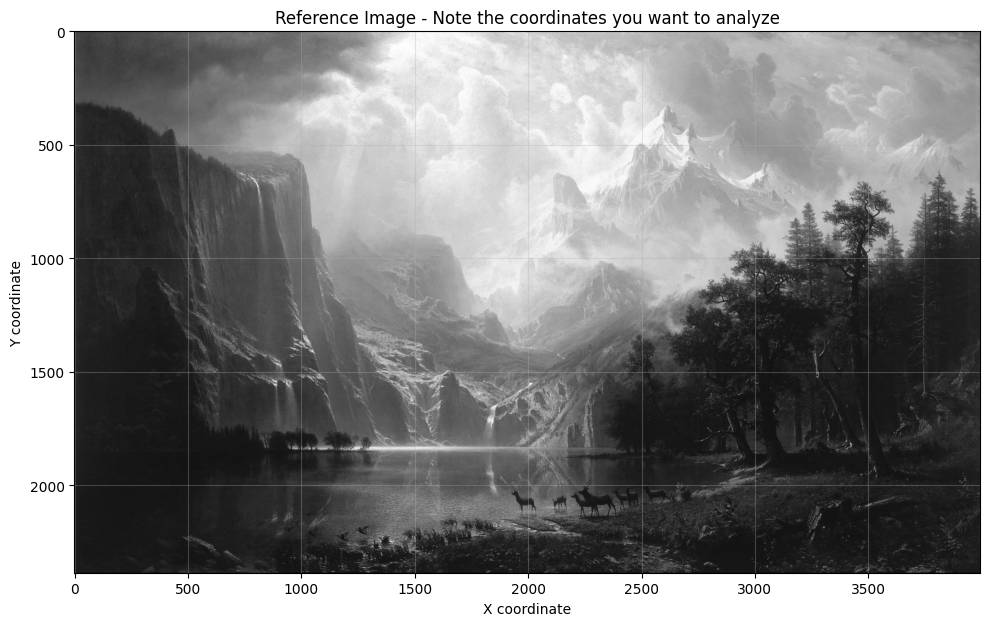

Image dimensions: 3993 x 2387 (width x height)
Enter coordinates to analyze, or press Enter for center point

Selected point: (1000, 3000)
Noise variance (np.var): 5330.6846
Local variance (np.var): 463.7691
Local variance (HF): 89.0207


In [9]:

# Simple coordinate input approach (most reliable for all environments)
import matplotlib.pyplot as plt
import pandas as pd

# Display the image for reference
fig_ref, ax_ref = plt.subplots(figsize=(10, 8))
ax_ref.imshow(original, cmap='gray', vmin=0, vmax=255)
ax_ref.set_title('Reference Image - Note the coordinates you want to analyze', fontsize=12)
ax_ref.set_xlabel('X coordinate')
ax_ref.set_ylabel('Y coordinate')
ax_ref.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Simple input method - just type coordinates
print(f"Image dimensions: {w} x {h} (width x height)")
print("Enter coordinates to analyze, or press Enter for center point")
user_input = input("Enter as 'x,y' (e.g., '100,200'): ").strip()

if user_input:
    try:
        parts = user_input.split(',')
        sel_x = int(parts[0].strip())
        sel_y = int(parts[1].strip())
        sel_x = int(np.clip(sel_x, 0, w - 1))
        sel_y = int(np.clip(sel_y, 0, h - 1))
    except:
        print("Invalid input, using center point")
        sel_x, sel_y = w // 2, h // 2
else:
    # Default to center
    sel_x, sel_y = w // 2, h // 2

s0 = (sel_y, sel_x)
print(f"\nSelected point: ({sel_y}, {sel_x})")

# Estimate variances for this point
sigma_n_sq_np = np.var(original)
sigma_l_sq_np = denoiser.estimate_local_variance(s0)
sigma_l_sq_hf = high_freq_var(denoiser.get_local_region_square(s0))

print(f"Noise variance (np.var): {sigma_n_sq_np:.4f}")
print(f"Local variance (np.var): {sigma_l_sq_np:.4f}")
print(f"Local variance (HF): {sigma_l_sq_hf:.4f}")

# Track visited pixels during MCMC
objective_values_np = []
objective_values_hf = []
intensities_visited_np = []
intensities_visited_hf = []

# Perform MCMC sampling
sigma_s = 10
num_iterations = 50

#for hf
s_prev = s0
for k in range(num_iterations):
    dy = np.random.normal(0, sigma_s)
    dx = np.random.normal(0, sigma_s)
    
    sk_y = int(np.clip(s_prev[0] + dy, 0, h - 1))
    sk_x = int(np.clip(s_prev[1] + dx, 0, w - 1))
    sk = (sk_y, sk_x)
    
    sigma_l_sq_sk_hf = high_freq_var(denoiser.get_local_region_square(sk))
    sigma_l_sq_prev_hf = high_freq_var(denoiser.get_local_region_square(s_prev))
    f_sk_hf = denoiser.compute_objective(s0, sk, sigma_n_sq_np, sigma_l_sq_sk_hf)
    f_prev_hf = denoiser.compute_objective(s0, s_prev, sigma_n_sq_np, sigma_l_sq_prev_hf)
    
    # Acceptance probability
    if f_prev_hf > 0:
        acceptance_prob = min(1.0, f_sk_hf / f_prev_hf)
    else:
        acceptance_prob = 1.0
    
    u = np.random.uniform(0, 1)
    if u <= acceptance_prob:
        objective_values_hf.append(float(f_sk_hf))
        intensities_visited_hf.append(original[sk])
        s_prev = sk

#for np.var
s_prev = s0
for k in range(num_iterations):
    dy = np.random.normal(0, sigma_s)
    dx = np.random.normal(0, sigma_s)
    
    sk_y = int(np.clip(s_prev[0] + dy, 0, h - 1))
    sk_x = int(np.clip(s_prev[1] + dx, 0, w - 1))
    sk = (sk_y, sk_x)
    
    # Compute objectives with both variance methods
    f_sk_np = denoiser.compute_objective(s0, sk, sigma_n_sq_np, sigma_l_sq_np)
    f_prev_np = denoiser.compute_objective(s0, s_prev, sigma_n_sq_np, sigma_l_sq_np)
    
    # Acceptance probability
    if f_prev_np > 0:
        acceptance_prob = min(1.0, f_sk_np / f_prev_np)
    else:
        acceptance_prob = 1.0
    
    u = np.random.uniform(0, 1)
    if u <= acceptance_prob:
        objective_values_np.append(float(f_sk_np))
        intensities_visited_np.append(original[sk])
        s_prev = sk

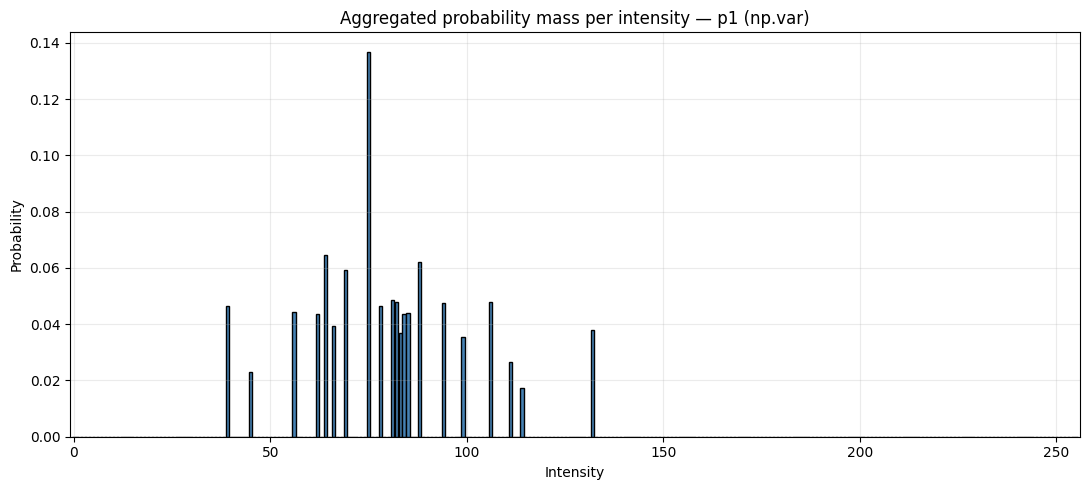

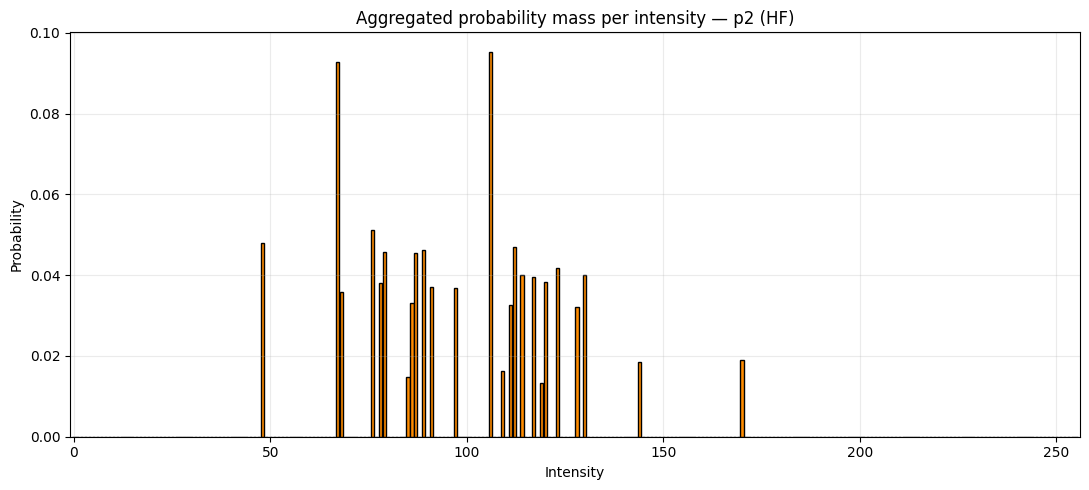

Original intensity at selected point: 67.00
Predicted intensity (p1): 79.53
Predicted intensity (p2): 97.15


In [10]:
"Pixel intensity graphs"



from numbers import Number

def to_1d_numeric(arr):
    """
    Convert arr (which may be a numpy array, list, list-of-arrays, etc.)
    into a flat 1-D numeric numpy array.
    """
    # If already numpy numeric array, just flatten
    if isinstance(arr, np.ndarray) and arr.dtype != object:
        return arr.ravel()

    # If it's a list-like and contains sub-sequences, try concatenating them
    if isinstance(arr, (list, tuple, np.ndarray)):
        # If elements are scalar-like, convert directly
        if all(isinstance(el, Number) for el in arr):
            return np.asarray(arr, dtype=float).ravel()
        # If elements are array-like, concatenate each element after converting to array
        try:
            pieces = []
            for el in arr:
                # convert each element to numeric numpy array
                a = np.asarray(el)
                if a.dtype == object:
                    # try to coerce nested lists recursively
                    a = to_1d_numeric(el)
                pieces.append(a.ravel())
            return np.concatenate(pieces).astype(float)
        except Exception:
            # fallback - try a direct asarray and then flatten (may raise)
            return np.asarray(arr, dtype=float).ravel()

    # last resort: try to convert directly
    return np.asarray(arr, dtype=float).ravel()


def aggregate_and_plot(F1, F2, p1, p2, clip_range=(0,255), show_plot=True, separate_plots=False):
    # convert to 1D numeric arrays
    F1 = to_1d_numeric(F1)
    F2 = to_1d_numeric(F2)
    p1 = to_1d_numeric(p1)
    p2 = to_1d_numeric(p2)


    # Normalize p1 and p2 (if sums > 0)
    if p1.sum() > 0:
        p1 = p1 / p1.sum()
    if p2.sum() > 0:
        p2 = p2 / p2.sum()

    # Round F to nearest integer and clip to the desired intensity range
    lo, hi = clip_range
    inds1 = np.rint(F1).astype(int)
    inds1 = np.clip(inds1, lo, hi)
    inds2 = np.rint(F2).astype(int)
    inds2 = np.clip(inds2, lo, hi)


    # Use bincount to aggregate probabilities per intensity
    minlength = hi - lo + 1
    agg_p1 = np.bincount(inds1 - lo, weights=p1, minlength=minlength).astype(float)
    agg_p2 = np.bincount(inds2 - lo, weights=p2, minlength=minlength).astype(float)

    # Optional re-normalize after aggregation (guard against tiny numerical drift)
    if agg_p1.sum() > 0:
        agg_p1 /= agg_p1.sum()
    if agg_p2.sum() > 0:
        agg_p2 /= agg_p2.sum()

    # Prepare x-axis values (intensities)
    x = np.arange(lo, hi + 1)

    if show_plot:
        width = 0.9
        if separate_plots:
            # Plot p1 on its own figure
            plt.figure(figsize=(11,5))
            plt.bar(x, agg_p1, width=width*0.9, align='center', color='steelblue', edgecolor='black')
            plt.xlim(lo - 1, hi + 1)
            plt.xlabel('Intensity')
            plt.ylabel('Probability')
            plt.title('Aggregated probability mass per intensity — p1 (np.var)')
            plt.grid(alpha=0.25)
            plt.tight_layout()
            plt.show()

            # Plot p2 on its own figure
            plt.figure(figsize=(11,5))
            plt.bar(x, agg_p2, width=width*0.9, align='center', color='darkorange', edgecolor='black')
            plt.xlim(lo - 1, hi + 1)
            plt.xlabel('Intensity')
            plt.ylabel('Probability')
            plt.title('Aggregated probability mass per intensity — p2 (HF)')
            plt.grid(alpha=0.25)
            plt.tight_layout()
            plt.show()
        else:
            # Combined figure with side-by-side bars
            plt.figure(figsize=(11,5))
            plt.bar(x - width*0.25, agg_p1, width=width*0.45, align='center', label='p1 (aggregated)')
            plt.bar(x + width*0.25, agg_p2, width=width*0.45, align='center', label='p2 (aggregated)')
            plt.xlim(lo - 1, hi + 1)
            plt.xlabel('Intensity')
            plt.ylabel('Probability')
            plt.title('Aggregated probability mass per intensity')
            plt.legend()
            plt.grid(alpha=0.25)
            plt.tight_layout()
            plt.show()

    predicted_intensity_p1 = np.sum(x * agg_p1)
    predicted_intensity_p2 = np.sum(x * agg_p2)
    original_intensity = original[s0]
    print(f"Original intensity at selected point: {original_intensity:.2f}")
    print(f"Predicted intensity (p1): {predicted_intensity_p1:.2f}")
    print(f"Predicted intensity (p2): {predicted_intensity_p2:.2f}")
    return x, agg_p1, agg_p2


# ---------------------------
# Example usage:
# ---------------------------
F1 = intensities_visited_np.copy()  # maybe list of ints, or list of numpy arrays, etc.
F2 = intensities_visited_hf.copy()
p1 = objective_values_np.copy()
p2 = objective_values_hf.copy()
# Plot separately as requested
x, agg_p1, agg_p2 = aggregate_and_plot(F1, F2, p1, p2, separate_plots=True)
